# The Football Lab: Predicting Player Impact by Position

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn 

In [164]:

raw_dataset_23 = pd.read_csv("datasets/2022-2023_Football_Player_Stats.csv", encoding="latin1")
raw_dataset_22 = pd.read_csv("datasets/2021-2022_Football_Player_Stats.csv", encoding="latin1")


## Cleaning & Structuring the Dataset

### Structuring the DataSet
Here in this section we're going to manipulate the dataset. The manipulation are made so it's easier to use it.     
Let's start adding a row with the name of all columns..

In [165]:
## Data Preprocessing
raw_dataset_22.loc[len(raw_dataset_22)] = raw_dataset_22.columns

raw_dataset_22 = raw_dataset_22.iloc[:,0].str.split(";", expand=True)
raw_dataset_22.columns =raw_dataset_22.iloc[len(raw_dataset_22)-1]

raw_dataset_22 = raw_dataset_22.drop(index =len(raw_dataset_22)-1)

raw_dataset_22.head()

2921,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Max Aarons,ENG,DF,Norwich City,Premier League,22,2000,34,32,...,0.03,1.41,1.16,0,0.06,0.03,5.53,0.47,1.59,22.7
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,1987,34,34,...,0,0.06,1.39,0,0.03,0,6.77,2.02,1.36,59.8
2,3,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2000,31,29,...,0,0.36,1.24,0,0,0,8.76,0.88,0.88,50
3,4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,1993,34,34,...,0.03,0.79,2.23,0,0,0,8.87,0.43,0.43,50
4,5,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,2000,1,1,...,0,2,0,0,0,0,4,2,0,100


In [166]:
## Data Preprocessing
raw_dataset_23.loc[len(raw_dataset_23)] = raw_dataset_23.columns

raw_dataset_23 = raw_dataset_23.iloc[:,0].str.split(";", expand=True)
raw_dataset_23.columns =raw_dataset_23.iloc[len(raw_dataset_23)-1]

raw_dataset_23 = raw_dataset_23.drop(index =len(raw_dataset_23)-1)

raw_dataset_23.head()

2689,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,0.17,2.54,0.51,0,0,0,4.86,0.34,1.19,22.2
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,0.05,0.18,1.59,0,0,0,6.64,2.18,1.23,64
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,0,1.05,1.4,0,0,0,8.14,0.93,1.05,47.1
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,0,0.35,0.8,0,0,0.05,6.6,0.5,0.5,50
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,0,0.23,2.02,0,0,0,6.51,0.31,0.39,44.4


Here we are going to delete all the non common columns between the two datasets and the duplicated row.

In [167]:
common_columns = raw_dataset_23.columns.intersection(raw_dataset_22.columns)

raw_dataset_22 = raw_dataset_22[common_columns]
raw_dataset_23 = raw_dataset_23[common_columns]

# Remove duplicates from the dataset
raw_dataset_22 = raw_dataset_22[~raw_dataset_22['Player'].duplicated(keep=False)]

# Remove Javier Llabrés from the datasets because the row in dataset 2021-2022 is incompleted
raw_dataset_22 = raw_dataset_22[raw_dataset_22['Player'] != 'Javier Llabrés']
raw_dataset_23 = raw_dataset_23[raw_dataset_23['Player'] != 'Javier Llabrés']


In [168]:
columns_to_keep = ["Player", "Nation", "Pos", "Squad", "Comp", "Age", "Min", "MP", "SoT%", "PasTotCmp%", "Goals", "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdY", "CrdR", "Recov"]

columns_to_convert = ["Min", "MP", "SoT%", "PasTotCmp%", "Goals", "Assists", "TklWon" , "Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdY", "CrdR", "Recov"]

raw_dataset_22["Min"] = raw_dataset_22["Min"].apply(lambda col: pd.to_numeric(col, errors='coerce'))
raw_dataset_23["Min"] = raw_dataset_23["Min"].apply(lambda col: pd.to_numeric(col, errors='coerce'))

column_not_to_norm = ["Player", "Nation", "Pos", "Comp", "Age", "Min", "MP", "SoT%", "PasTotCmp%"]

dataset_22 = raw_dataset_22[columns_to_keep]
dataset_23 = raw_dataset_23[columns_to_keep]

for col in columns_to_convert:
    dataset_22.loc[:, col] = pd.to_numeric(dataset_22[col], errors='coerce')
    dataset_23.loc[:, col] = pd.to_numeric(dataset_23[col], errors='coerce')

In this section we are going to normalize certain columns for the season.

In [169]:
# here we are going to normalize all the columns as follows:
# value = value * Minutes Played / 90

columns_to_normalize = ["Goals", "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdR", "Recov"]


for index, line in dataset_22.iterrows():
    for column in columns_to_normalize:
        dataset_22.at[index, column] = round(dataset_22.at[index, column] * raw_dataset_22.at[index, "Min"] / 90, 0)



columns_to_normalize = [ "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdR", "Recov"]

for index, line in dataset_23.iterrows():
    for column in columns_to_normalize:
        dataset_23.at[index, column] = round(dataset_23.at[index, column] * raw_dataset_23.at[index, "Min"] / 90, 0)

dataset_22.head()

2921,Player,Nation,Pos,Squad,Comp,Age,Min,MP,SoT%,PasTotCmp%,...,TouDef3rd,AerWon,Err,Fls,PasLonCmp,PasLonAtt,PasDead,CrdY,CrdR,Recov
0,Max Aarons,ENG,DF,Norwich City,Premier League,22,2881,34,15.4,75.5,...,746.0,15.0,0.0,31.0,98.0,217.0,339.0,0.25,0.0,177.0
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,2983,34,33.3,82.4,...,1087.0,67.0,0.0,43.0,187.0,303.0,100.0,0.15,1.0,224.0
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2462,31,27.8,91.7,...,621.0,24.0,0.0,45.0,184.0,214.0,20.0,0.44,3.0,240.0
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,2956,34,23.3,81.6,...,450.0,14.0,0.0,46.0,205.0,308.0,28.0,0.27,0.0,291.0
4,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,45,1,0.0,33.3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [170]:
dataset_23.head()

2689,Player,Nation,Pos,Squad,Comp,Age,Min,MP,SoT%,PasTotCmp%,...,TouDef3rd,AerWon,Err,Fls,PasLonCmp,PasLonAtt,PasDead,CrdY,CrdR,Recov
0,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,1596,20,18.5,74.9,...,77.0,6.0,1.0,11.0,16.0,42.0,51.0,0.11,0.0,86.0
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1980,22,5.3,81.5,...,605.0,48.0,1.0,29.0,83.0,154.0,82.0,0.09,0.0,146.0
2,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,770,14,33.3,80.8,...,98.0,8.0,0.0,15.0,38.0,51.0,10.0,0.12,0.0,70.0
3,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,1799,20,25.0,91.6,...,240.0,10.0,0.0,49.0,67.0,86.0,28.0,0.15,0.0,132.0
4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1165,15,0.0,87.3,...,249.0,4.0,0.0,12.0,34.0,51.0,10.0,0.16,0.0,84.0


## Visualization part

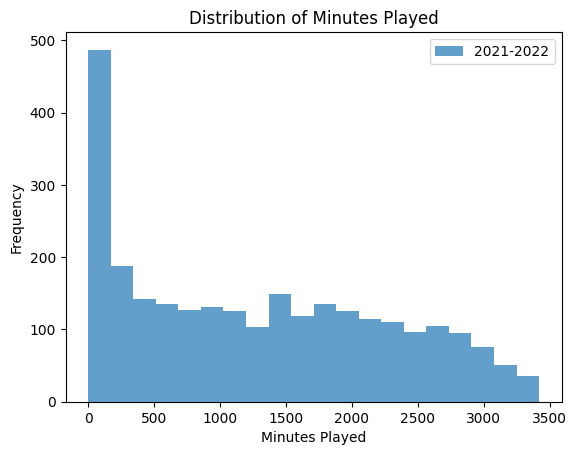

In [171]:
plt.hist(dataset_22["Min"], bins=20, alpha=0.7, label="2021-2022")
plt.xlabel("Minutes Played")
plt.ylabel("Frequency")
plt.title("Distribution of Minutes Played")
plt.legend()
plt.show()

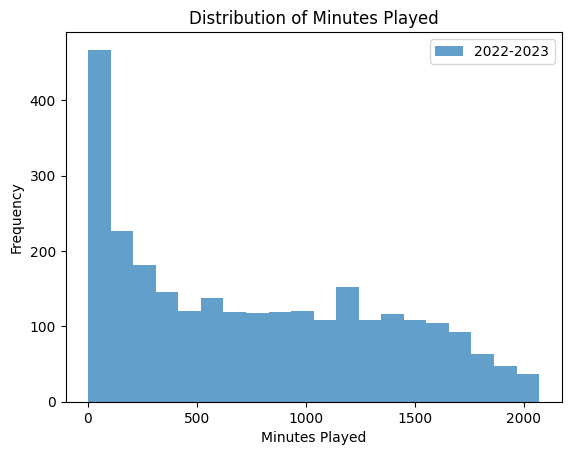

In [172]:
plt.hist(dataset_23["Min"], bins=20, alpha=0.7, label="2022-2023")
plt.xlabel("Minutes Played")
plt.ylabel("Frequency")
plt.title("Distribution of Minutes Played")
plt.legend()
plt.show()

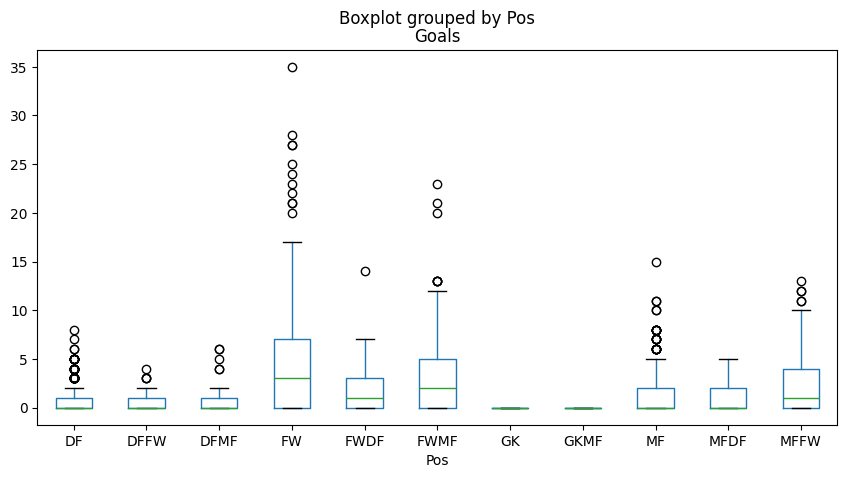

In [173]:
dataset_22.boxplot(column="Goals", by="Pos", grid=False, figsize=(10, 5))
plt.show()



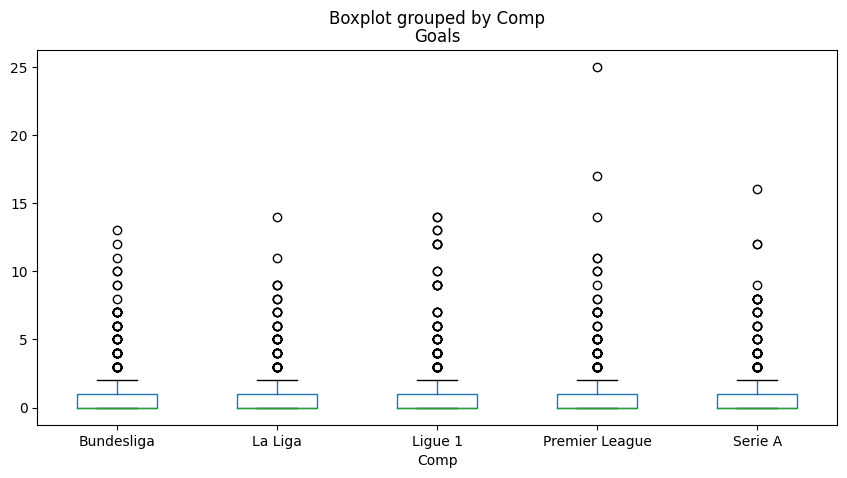

In [174]:
dataset_23.boxplot(column="Goals", by="Comp", grid=False, figsize=(10, 5))
plt.show()

## OLAP